## Learnings:
   <li> The accuracy of the model was 3%! This was fixed by scaling the pixel values between 0-1.
   <li> How to save and load models onto the disk (see the last cell)

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import random

import warnings
warnings.filterwarnings('ignore')

/home/vismay/Vismay/Softwares/Anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
dataset_path = "./../Dataset/'German Traffic Signs'/gtsrb-german-traffic-sign/"
train_csv = "Train.csv"
test_csv = "Test.csv"

%cd $dataset_path
train_dataset = pd.read_csv(train_csv)

/home/vismay/Vismay/Learning/ML Stuff/Projects/German Road Signs/Dataset/German Traffic Signs/gtsrb-german-traffic-sign


### <center>Plotting the frequency distribution of the classes (i.e types of road signs) </center>

Text(0,0.5,'Count')

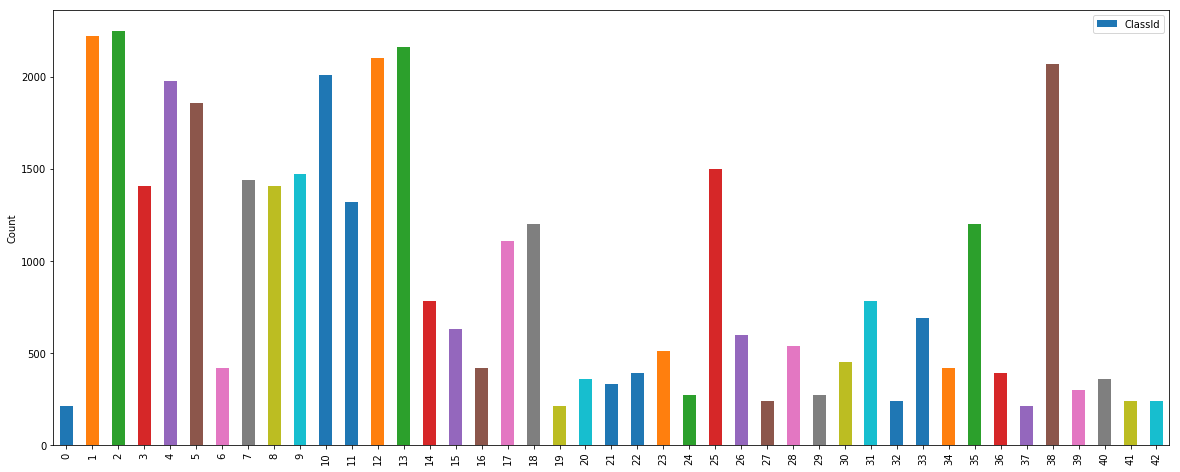

In [3]:
class_frequency = train_dataset['ClassId'].value_counts().sort_index()
class_frequency.plot(kind='bar', legend=True, figsize=(20,8)).set_ylabel('Count')

In [4]:
train_dataset.columns

Index(['Width', 'Height', 'Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2', 'ClassId',
       'Path'],
      dtype='object')

In [5]:
# Load images from the dataset and then:
#   1. Resize to 32x32 pixels
#   2. Convert RGB to greyscale
#   3. Use histogram equalization to improve the contrast of the image
#   4. Scale the pixel values betwenn 0 to 1
#   5. Store the corresponding labels

train_images = []
train_labels = []
image_dim = (32,32)
no_of_images = train_dataset['Path'].shape[0]

for i in range(no_of_images):
    try:
        img = cv2.imread(train_dataset['Path'][i])
        img_resized = cv2.resize(img, image_dim)
        img_grayscale = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
        img_hist_equalized = cv2.equalizeHist(img_grayscale)
        img_scaled = img_hist_equalized/255.0
        # AAARRRGGGHHHH train_images.append(img_hist_equalized)
        train_images.append(img_scaled)
        train_labels.append(train_dataset['ClassId'][i])
    except Exception as e:
        print('Index: ' + i + ' ' + str(e))
        
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [6]:
print(f"Dimensions of the dataset: {train_images.shape}, {train_labels.shape}")
print(f"The classes of images in the current dataset are {np.unique(train_labels)}")

Dimensions of the dataset: (39209, 32, 32), (39209,)
The classes of images in the current dataset are [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42]


In [7]:
# By observing the various road signs in Meta, it can be observed that certain road signs can be flipped/
# inverted or rotated to get other road signs, or the same road signs. This augmentation technique can be
# used to balance the dataset, i.e add more samples for classes that have a small number of samples.

def flip_images(images_to_flip, source_label, target_label, flip_orientation):
    flipped_images = []
    flipped_img_labels = []
    for img in range(images_to_flip.shape[0]):
        original_img = images_to_flip[img]
        #print(f"Type: {type(original_img)} and shape before flipping: {original_img.shape}")
        flipped_img = cv2.flip(original_img, flip_orientation)
        #print(f"Type: {type(flipped_img)} and shape after flipping: {flipped_img.shape}")
        flipped_images.append(flipped_img)
        flipped_img_labels.append(target_label)
    flipped_images = np.array(flipped_images)
    flipped_img_labels = np.array(flipped_img_labels)
    print(f"Assigning class {target_label}")
    return {'flipped_images':flipped_images, 'labels':flipped_img_labels}

# Road signs which, when flipped horizontally give the same sign. Example: class 11
horizontally_self_flippable_signs = [11, 12, 13, 15, 17, 18, 22, 26, 30, 35]

# Road signs which, when flipped vertically give the same sign. Example: Class 1
vertically_self_flippable_signs = [1, 5, 12, 15, 17]

# Road signs which, when flipped horizontally, then vertically give the same sign. Example: Class 32.
self_flippable_both = [32, 40]

# Road signs which, when flipped horizontally give another sign from the dataset. Example: Horizontally flipping class 33 gives class 34
horizontally_cross_flippable_signs = np.array([[19, 20], [33, 34], [36, 37],  [38, 39], [20, 19],  [34, 33], [37, 36], [39, 38]])

num_classes = 43
h_flip_self = []
v_flip = []
both_flip = []
h_flip_cross = []
flipped_images = np.array([])
flipped_img_labels = np.array([])

for c in range(num_classes):
    if c in np.unique(train_labels):
        if c in horizontally_self_flippable_signs:
            images_to_flip = train_images[train_labels==c]
            print(f"Class {c}: Horizontal self flip - {images_to_flip.shape}")
            h_flip_self = flip_images(images_to_flip, c, c, 1)
            if flipped_images.size == 0:
                flipped_images = h_flip_self['flipped_images']
                flipped_img_labels = h_flip_self['labels']
            else:
                flipped_images = np.append(flipped_images, h_flip_self['flipped_images'], axis=0)
                flipped_img_labels = np.append(flipped_img_labels, h_flip_self['labels'], axis=0)
        
        if c in vertically_self_flippable_signs:
            images_to_flip = train_images[train_labels==c]
            print(f"Class {c}: Vertical flip - {images_to_flip.shape}")
            v_flip = flip_images(images_to_flip, c, c, 0)
            if flipped_images.size == 0:
                flipped_images = v_flip['flipped_images']
                flipped_img_labels = v_flip['labels']
            else:
                flipped_images = np.append(flipped_images, v_flip['flipped_images'], axis=0)
                flipped_img_labels = np.append(flipped_img_labels, v_flip['labels'], axis=0)
            
        if c in self_flippable_both:
            images_to_flip = train_images[train_labels==c]
            print(f"Class {c}: V & H flip - {images_to_flip.shape}")
            both_flip = flip_images(images_to_flip, c, c, -1)
            if flipped_images.size == 0:
                flipped_images = both_flip['flipped_images']
                flipped_img_labels = both_flip['labels']
            else:
                flipped_images = np.append(flipped_images, both_flip['flipped_images'], axis=0)
                flipped_img_labels = np.append(flipped_img_labels, both_flip['labels'], axis=0)
                    
        if c in horizontally_cross_flippable_signs[:,0]:
            source_label = c
            target_label_index = np.where(horizontally_cross_flippable_signs[:,0]==c)[0][0]
            target_label = horizontally_cross_flippable_signs[target_label_index][1]
            images_to_flip = train_images[train_labels==c]
            print(f"Class {c}: Horizontal cross flip - {images_to_flip.shape}")
            h_flip_cross = flip_images(images_to_flip, source_label, target_label, 1)
            if flipped_images.size == 0:
                flipped_images = h_flip_cross['flipped_images']
                flipped_img_labels = h_flip_cross['labels']
            else:
                flipped_images = np.append(flipped_images, h_flip_cross['flipped_images'], axis=0)
                flipped_img_labels = np.append(flipped_img_labels, h_flip_cross['labels'], axis=0)
print(f"Dimensions of flipped images: {flipped_images.shape} and labels: {flipped_img_labels.shape}")                

Class 1: Vertical flip - (2220, 32, 32)
Assigning class 1
Class 5: Vertical flip - (1860, 32, 32)
Assigning class 5
Class 11: Horizontal self flip - (1320, 32, 32)
Assigning class 11
Class 12: Horizontal self flip - (2100, 32, 32)
Assigning class 12
Class 12: Vertical flip - (2100, 32, 32)
Assigning class 12
Class 13: Horizontal self flip - (2160, 32, 32)
Assigning class 13
Class 15: Horizontal self flip - (630, 32, 32)
Assigning class 15
Class 15: Vertical flip - (630, 32, 32)
Assigning class 15
Class 17: Horizontal self flip - (1110, 32, 32)
Assigning class 17
Class 17: Vertical flip - (1110, 32, 32)
Assigning class 17
Class 18: Horizontal self flip - (1200, 32, 32)
Assigning class 18
Class 19: Horizontal cross flip - (210, 32, 32)
Assigning class 20
Class 20: Horizontal cross flip - (360, 32, 32)
Assigning class 19
Class 22: Horizontal self flip - (390, 32, 32)
Assigning class 22
Class 26: Horizontal self flip - (600, 32, 32)
Assigning class 26
Class 30: Horizontal self flip - (450,

In [8]:
print(f"Dimensions of the dataset before adding flipped images: {train_images.shape} and labels: {train_labels.shape}")

# Append the flipped images to the original dataset
train_images = np.append(train_images, flipped_images, axis=0)
train_labels = np.append(train_labels, flipped_img_labels, axis=0)
print(f"Dimensions of the dataset after adding flipped images: {train_images.shape} and labels: {train_labels.shape}")

Dimensions of the dataset before adding flipped images: (39209, 32, 32) and labels: (39209,)
Dimensions of the dataset after adding flipped images: (63538, 32, 32) and labels: (63538,)


In [9]:
# Creating a balanced dataset
"""num_class = 43
balanced_data = []
balanced_labels = []
for c in range(num_classes):
    class_c_signs = np.where(train_labels==c)[0]
    sample_count = 200
    indices = random.sample(range(0, len(class_c_signs)), sample_count)
    for i in range(sample_count):
        balanced_data.append(train_images[class_c_signs[i]])
        balanced_labels.append(c)

balanced_data = np.array(balanced_data)
balanced_labels = np.array(balanced_labels)"""

'num_class = 43\nbalanced_data = []\nbalanced_labels = []\nfor c in range(num_classes):\n    class_c_signs = np.where(train_labels==c)[0]\n    sample_count = 200\n    indices = random.sample(range(0, len(class_c_signs)), sample_count)\n    for i in range(sample_count):\n        balanced_data.append(train_images[class_c_signs[i]])\n        balanced_labels.append(c)\n\nbalanced_data = np.array(balanced_data)\nbalanced_labels = np.array(balanced_labels)'

In [10]:
cv2.imshow('image',train_images[385])
cv2.waitKey(0)
cv2.destroyAllWindows()

In [11]:
# Apply additional transformations such as image translation and shearing.
# Randomly choose 10% of the images from each class and apply the transformations.

# Will be done later

In [12]:
# One-hot-encode the image labels
number_of_classes = 43
train_labels = np.eye(43)[train_labels]


In [13]:
# Use train_test_split() to create a hold out validation dataset
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.20)
print(f"Dimensions of training data and labels: {X_train.shape} {y_train.shape}")
print(f"Dimensions of validation data and labels: {X_val.shape} {y_val.shape}")



"""bal_X_train, bal_X_val, bal_y_train, bal_y_val = train_test_split(balanced_data, balanced_labels, test_size=0.20)
print(f"Dimensions of training data and labels: {bal_X_train.shape} {bal_y_train.shape}")
print(f"Dimensions of validation data and labels: {bal_X_val.shape} {bal_y_val.shape}")"""

Dimensions of training data and labels: (50830, 32, 32) (50830, 43)
Dimensions of validation data and labels: (12708, 32, 32) (12708, 43)


'bal_X_train, bal_X_val, bal_y_train, bal_y_val = train_test_split(balanced_data, balanced_labels, test_size=0.20)\nprint(f"Dimensions of training data and labels: {bal_X_train.shape} {bal_y_train.shape}")\nprint(f"Dimensions of validation data and labels: {bal_X_val.shape} {bal_y_val.shape}")'

In [14]:
# Reshape the data to make it compatible with the input_shape of the CNN
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], X_val.shape[2], 1))

In [15]:
# The architecture of the CNN is as described in: http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf


# Build the CNN model
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

# Conv layer 1
conv_model = Sequential()
conv_model.add(Conv2D(32, kernel_size=5, input_shape=(32,32,1), padding='same', activation='relu'))
conv_model.add(MaxPool2D((2,2)))
#conv_model.add(Dropout(0.1))

# Conv layer 2
conv_model.add(Conv2D(64, kernel_size=5, padding='same', activation='relu'))
conv_model.add(MaxPool2D(2,2))
#conv_model.add(Dropout(0.2))

# Conv layer 3
conv_model.add(Conv2D(128, kernel_size=5, padding='same', activation='relu'))
conv_model.add(MaxPool2D(2,2))
#conv_model.add(Dropout(0.3))

# Flatten
conv_model.add(Flatten())
#conv_model.add(Dropout(0.5))

# Fully connected layer 1:
conv_model.add(Dense(1024, activation='relu'))

# Output layer
conv_model.add(Dense(43, activation='softmax'))

conv_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        832       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        51264     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
__________

In [19]:
# Train the CNN

conv_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

conv_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5)


Train on 50830 samples, validate on 12708 samples
Epoch 1/5
50830/50830 [==============================] - 288s 6ms/step - loss: 0.2151 - acc: 0.9324 - val_loss: 0.1175 - val_acc: 0.9644
Epoch 2/5
50830/50830 [==============================] - 289s 6ms/step - loss: 0.0820 - acc: 0.9737 - val_loss: 0.1114 - val_acc: 0.9667
Epoch 3/5
50830/50830 [==============================] - 289s 6ms/step - loss: 0.0535 - acc: 0.9834 - val_loss: 0.0607 - val_acc: 0.9840
Epoch 4/5
50830/50830 [==============================] - 307s 6ms/step - loss: 0.0478 - acc: 0.9852 - val_loss: 0.0869 - val_acc: 0.9786
Epoch 5/5
50830/50830 [==============================] - 287s 6ms/step - loss: 0.0398 - acc: 0.9881 - val_loss: 0.0992 - val_acc: 0.9754


In [20]:
!pip install h5py

You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [21]:
# How to save and load models to disk: https://machinelearningmastery.com/save-load-keras-deep-learning-models/

# serialize model to JSON
model_json = conv_model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
conv_model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk
